In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import pyplot
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from collections import Counter
from keras import callbacks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend
from random import shuffle
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

Let's import and get an overview of our data, this dayta relates to shootings in NYC

In [2]:
data=pd.read_csv('/content/NYPD_Shooting_Incident_Data__Historic_.csv')

In [3]:
data.head() #see a small sample of the data

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


In [4]:
#Information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             27312 non-null  int64  
 1   OCCUR_DATE               27312 non-null  object 
 2   OCCUR_TIME               27312 non-null  object 
 3   BORO                     27312 non-null  object 
 4   LOC_OF_OCCUR_DESC        1716 non-null   object 
 5   PRECINCT                 27312 non-null  int64  
 6   JURISDICTION_CODE        27310 non-null  float64
 7   LOC_CLASSFCTN_DESC       1716 non-null   object 
 8   LOCATION_DESC            12335 non-null  object 
 9   STATISTICAL_MURDER_FLAG  27312 non-null  bool   
 10  PERP_AGE_GROUP           17968 non-null  object 
 11  PERP_SEX                 18002 non-null  object 
 12  PERP_RACE                18002 non-null  object 
 13  VIC_AGE_GROUP            27312 non-null  object 
 14  VIC_SEX               

Ok so LOC_CLASSFCTN_DESC  and LOC_OF_OCCUR_DESC are 90+% Null so no replacement can really be done! Drop them. I also will note that income is not present, this is an issue in my opinion as to me income and sociual group is far more important than age or race.

In [5]:
data.drop(['LOC_CLASSFCTN_DESC','LOC_OF_OCCUR_DESC'],axis=1,inplace=True)
%%data source=https://catalog.data.gov/dataset?q=nyc+demographics&sort=views_recent+desc&tags=crime&ext_location=&ext_bbox=&ext_prev_extent=%%

In [6]:
data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,105,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,40,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,108,0.0,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,47,0.0,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


Let's look first at Boro and Percinct first

In [7]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

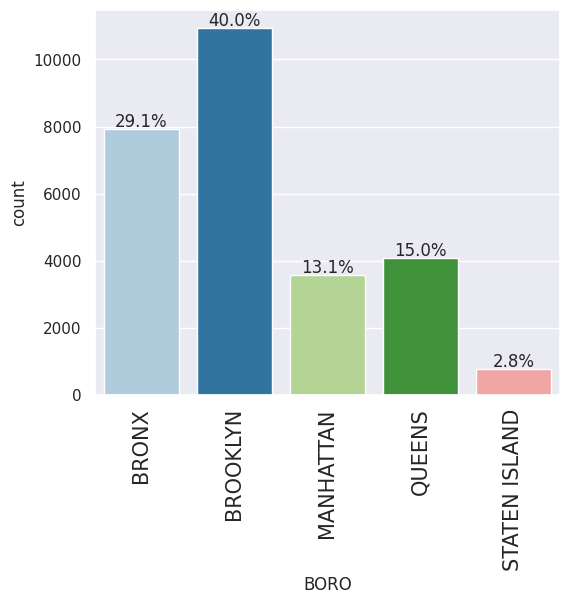

In [9]:
labeled_barplot(data, "BORO", perc=True)


So 40% of shootings occur in Brooklyn while making about 30% of the population. Staten Island is the lowest in both regard making 2,8% of shootings and about 6% of the population. At the moment it is irresponsible to assume this is significant. I will create a new data frame based on the data found here:https://www.citypopulation.de/en/usa/newyorkcity/


In [29]:
data_bb=[['BRONX',1379946],['BROOKLYN',2590516],['MANHATTAN',1596273],['QUEENS',2278029],['STATEN ISLAND',491133]]
data2=pd.DataFrame(data=data_bb, columns=['Boro','Population'])

In [30]:
total_pop=data2['Population'].sum()
total_pop
perc=data2['Population']/total_pop*100
data2['Percent']=perc

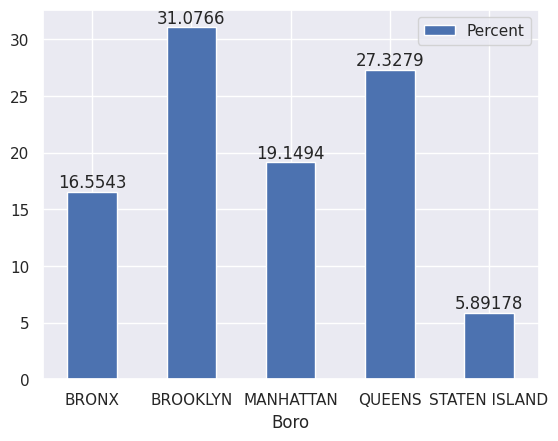

In [31]:
ax=data2.plot.bar(x='Boro',y="Percent",rot=0)
for container in ax.containers:
  ax.bar_label(container)

Bronx and Brooklyn appear to make up a higher  percentage of murders than population, while the reverse is true of Manhattan and Queens and Staten.

For PRECINCT I will create a mini data set for each BORO, I am not an expert on NYC but my understanding is each PRECINCT can be in one BORO and this will help visualize it more easily

In [33]:
BRONX_data=data.query('BORO=="BRONX"')
BRONX_data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
1,137471050,06/27/2014,17:40:00,BRONX,40,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
3,146837977,10/09/2015,18:30:00,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,47,0.0,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)
13,78961869,05/25/2011,21:58:00,BRONX,50,0.0,NaN,False,UNKNOWN,U,UNKNOWN,18-24,M,WHITE,1.010353e+06,261534.281250,40.884495,-73.905599,POINT (-73.90559937499995 40.884494922000044)
15,32914993,07/05/2007,01:27:00,BRONX,47,2.0,MULTI DWELL - PUBLIC HOUS,False,UNKNOWN,M,UNKNOWN,18-24,M,BLACK,1.026013e+06,261421.125000,40.884124,-73.848968,POINT (-73.84896796399994 40.88412413300006)


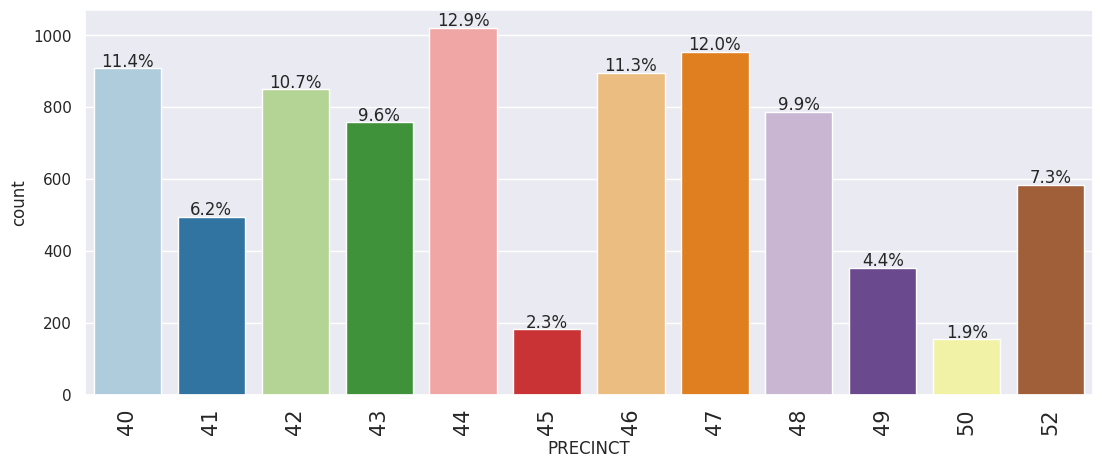

In [34]:

labeled_barplot(BRONX_data, "PRECINCT", perc=True)

40,44,46, and 47 all have above 10+% of shootings here. I will in the future try to find precinct level data for population

In [35]:
BROOKLYN_data=data.query('BORO=="BROOKLYN"')
BROOKLYN_data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
5,219559682,10/21/2020,21:36:00,BROOKLYN,81,0.0,NaN,True,NaN,NaN,NaN,25-44,M,BLACK,1.004234e+06,186461.703125,40.678457,-73.927952,POINT (-73.92795224099996 40.678456718000064)
7,71662474,03/08/2010,19:41:00,BROOKLYN,81,0.0,NaN,True,NaN,NaN,NaN,18-24,M,BLACK,1.002883e+06,192219.703125,40.694264,-73.932809,POINT (-73.93280863699994 40.694264056000065)
11,74363835,08/29/2010,01:27:00,BROOKLYN,75,0.0,GROCERY/BODEGA,False,25-44,M,BLACK,25-44,M,BLACK,1.013136e+06,179968.000000,40.660608,-73.895887,POINT (-73.89588694299994 40.66060839100004)
12,234756217,10/09/2021,20:17:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,9.961480e+05,181562.000000,40.665023,-73.957114,POINT (-73.95711436799998 40.66502269100005)
14,53891791,11/09/2008,20:13:00,BROOKLYN,78,2.0,MULTI DWELL - PUBLIC HOUS,False,UNKNOWN,U,UNKNOWN,25-44,M,BLACK HISPANIC,9.883984e+05,187950.625000,40.682565,-73.985044,POINT (-73.98504421199993 40.682565055000055)


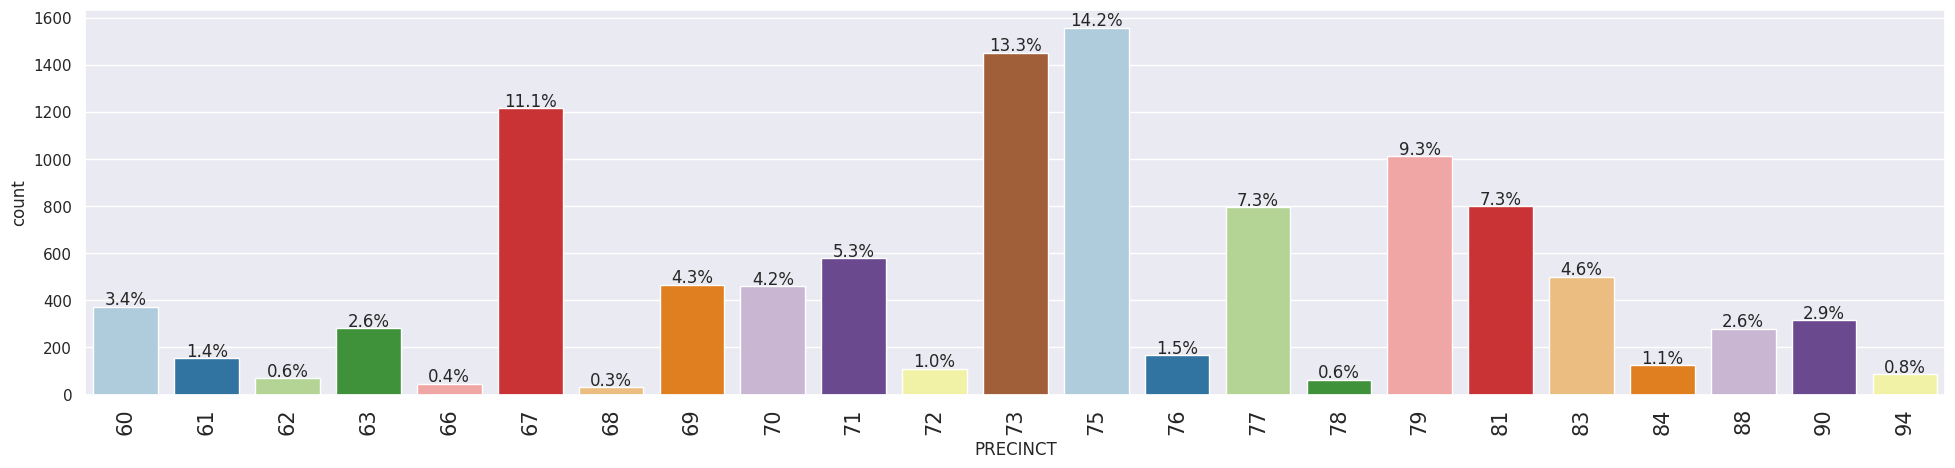

In [36]:

labeled_barplot(BROOKLYN_data, "PRECINCT", perc=True)

73 and 75 have very high number of shootings, 67 is close behind, 74 seems to be missing

In [37]:
MANHATTAN_data=data.query('BORO=="MANHATTAN"')
MANHATTAN_data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
10,74998200,10/10/2010,03:21:00,MANHATTAN,23,2.0,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,25-44,M,BLACK,999061.3750,229911.671875,40.797726,-73.946507,POINT (-73.94650650799997 40.79772626500005)
16,73879554,07/27/2010,02:22:00,MANHATTAN,30,0.0,NaN,True,25-44,M,BLACK,25-44,M,BLACK,999967.4375,240325.562500,40.826308,-73.943210,POINT (-73.94320965699995 40.82630793100003)
20,140791304,02/01/2015,23:16:00,MANHATTAN,30,0.0,NaN,True,18-24,M,BLACK,18-24,F,BLACK,996721.6875,238202.937500,40.820487,-73.954941,POINT (-73.95494146299995 40.82048710500004)
30,10187514,01/21/2006,21:49:00,MANHATTAN,28,0.0,NaN,True,18-24,M,BLACK,18-24,M,BLACK,996400.8125,233385.218750,40.807264,-73.956109,POINT (-73.95610949899998 40.807264259000085)
40,233762539,09/18/2021,19:41:00,MANHATTAN,23,2.0,MULTI DWELL - PUBLIC HOUS,False,18-24,M,BLACK,25-44,M,WHITE HISPANIC,998288.0000,227463.000000,40.791007,-73.949305,POINT (-73.94930485999998 40.79100658600004)


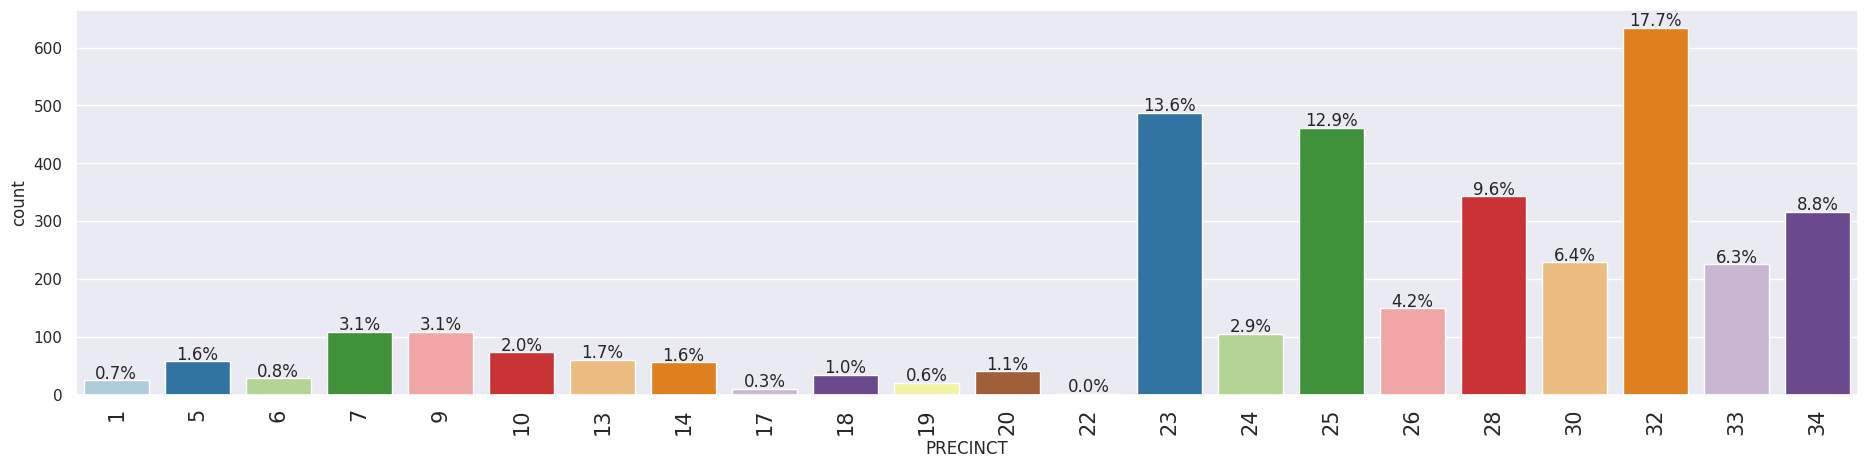

In [38]:
labeled_barplot(MANHATTAN_data, "PRECINCT", perc=True)

A number of precincts appear missing, those with higher numbers seem to have more shootings

In [39]:
QUEENS_data=data.query('BORO=="QUEENS"')
QUEENS_data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,105,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
2,147998800,11/21/2015,03:56:00,QUEENS,108,0.0,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
6,85295722,06/17/2012,22:47:00,QUEENS,114,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,9.988600e+05,214885.000000,40.756482,-73.947266,POINT (-73.94726649399996 40.75648234300007)
8,83002139,02/05/2012,05:45:00,QUEENS,105,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,1.054366e+06,196628.406250,40.706107,-73.747107,POINT (-73.74710653899996 40.706106731000034)
9,86437261,08/26/2012,01:10:00,QUEENS,101,0.0,MULTI DWELL - APT BUILD,False,25-44,M,BLACK,25-44,M,BLACK,1.053937e+06,157130.421875,40.597697,-73.749065,POINT (-73.74906464199995 40.59769719800005)


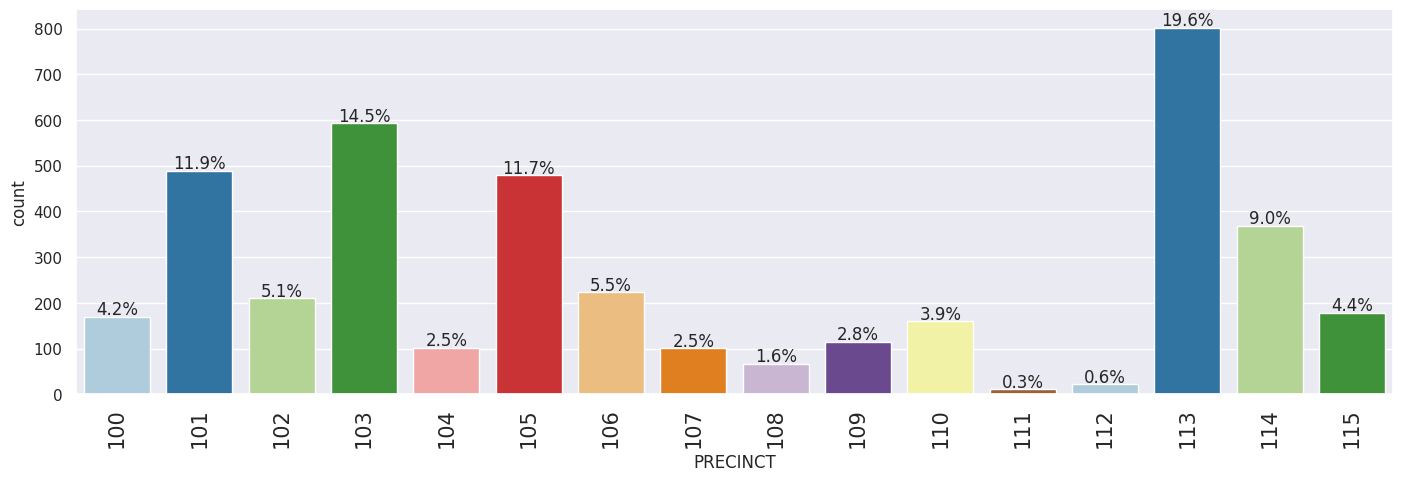

In [40]:
labeled_barplot(QUEENS_data, "PRECINCT", perc=True)

118 has a lot of shootings while some have bet to none

In [41]:
STATEN_data=data.query('BORO=="STATEN ISLAND"')
STATEN_data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
34,174579538,02/08/2018,20:16:00,STATEN ISLAND,120,0.0,NaN,False,18-24,M,BLACK HISPANIC,45-64,M,BLACK,962950.6875,172726.906250,40.640755,-74.076748,POINT (-74.07674821299997 40.64075466000003)
54,72058235,04/03/2010,04:00:00,STATEN ISLAND,120,2.0,MULTI DWELL - PUBLIC HOUS,False,18-24,M,WHITE HISPANIC,18-24,M,BLACK,961252.0000,166311.203125,40.623141,-74.082847,POINT (-74.08284714299998 40.623140669000065)
159,52380391,10/21/2008,01:55:00,STATEN ISLAND,120,0.0,NaN,False,18-24,M,BLACK,18-24,M,BLACK,962748.0000,174174.000000,40.644726,-74.077483,POINT (-74.07748315899994 40.64472613100003)
182,87349060,10/21/2012,21:36:00,STATEN ISLAND,120,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK HISPANIC,941189.1250,169903.500000,40.632926,-74.155142,POINT (-74.15514244599996 40.63292595300004)
258,74451277,09/02/2010,03:45:00,STATEN ISLAND,120,0.0,MULTI DWELL - APT BUILD,False,NaN,NaN,NaN,<18,M,BLACK,961417.5625,164057.234375,40.616954,-74.082243,POINT (-74.08224311499998 40.61695442300004)


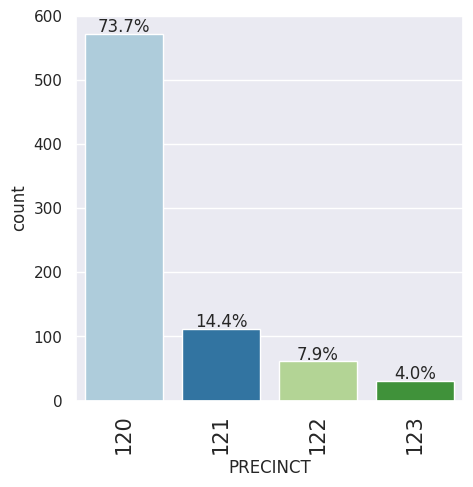

In [42]:
labeled_barplot(STATEN_data, "PRECINCT", perc=True)

Almost 3/4 of all shootings in Staten island happend in 120

I would now like to look at personal factors of victims, though again I would have liked class data we will settle for race, age, and gender

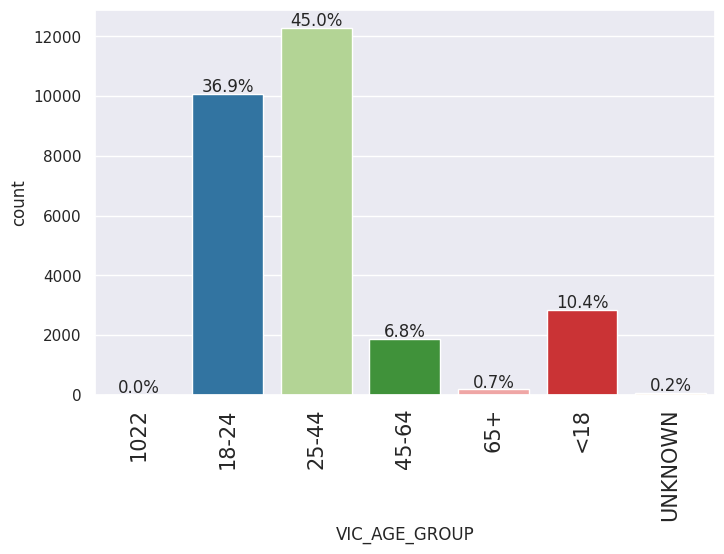

In [43]:

labeled_barplot(data, "VIC_AGE_GROUP", perc=True)

According to the census 16.8% of NYC is under 18, this is higher than reported victims suggesting  they are less likely to be shot,with ther rate of them being shot being roughly 62% of their population Seems like a good outcome though the fact over 10% of victims are kids is disturbing still

18-24 years olds make up a mere 10.2% of the population meaning they are 3.75 times more likely than rnadom to be victims of a shooting.

25-44 years olds are 38.3% of the population so the rate of shotoing were they are the victims roughly lines up with their population, the icnreas ebeing about 14%

45-64 years olds are 22.6% of the population, meaning they are much less liekly to be shot than random with the rate of shototing being 39% of the percent of their population

65+ years olds are even more skewed with a population percenatge  of 12.2% they are 17.5 times LESS liklely to be shot than random

There is a weird 1022 data point here, I assume this is a typo so lets drop it and chekc again

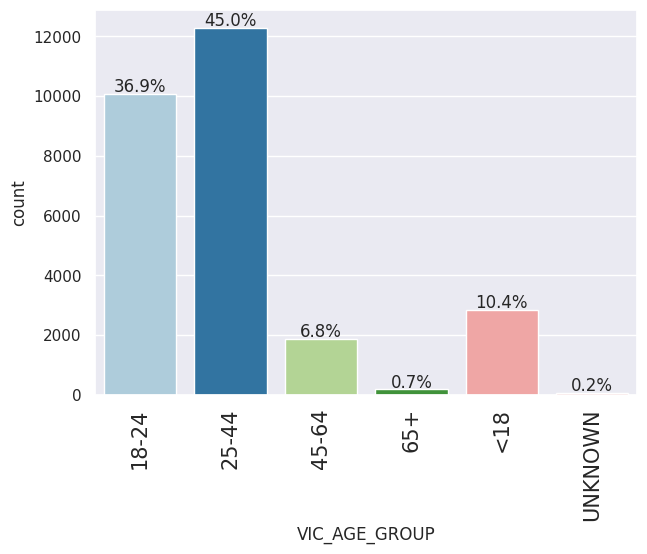

In [46]:
data=data.drop(data[data['VIC_AGE_GROUP']=='1022'].index)
labeled_barplot(data, "VIC_AGE_GROUP", perc=True)

I will do gender next

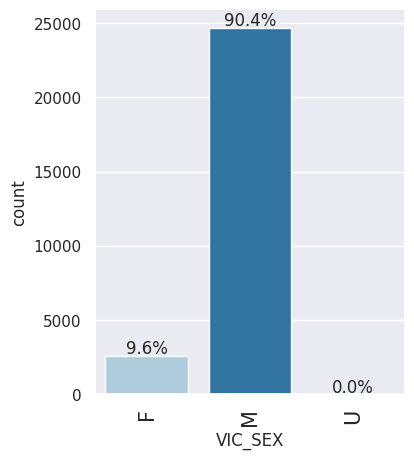

In [47]:
labeled_barplot(data, "VIC_SEX", perc=True)

A few points to note, the data seems to use biological sex so this can not be used to look at data like trans gender related violence and there are, as always, a few unknowns. I am not sure if these people were missing certain parts that would make that disctinction or if perhaps no victim was found, may be worth checking out if possible,

That said men make up 48% of the population but over 90% of shooting victims, so it may be worth exploring the relationship between gender and violence when given more detailed data

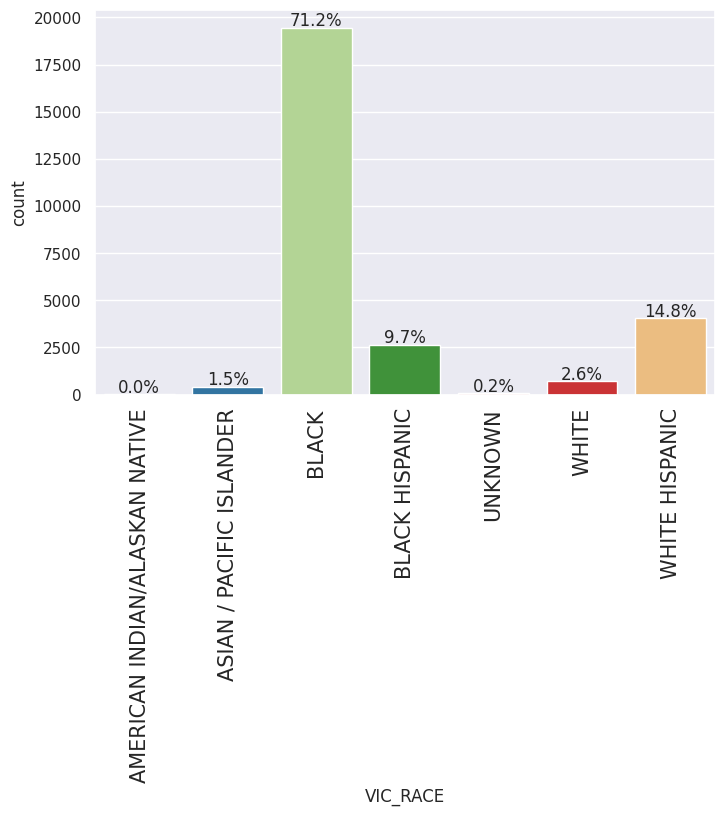

In [48]:
labeled_barplot(data, "VIC_RACE", perc=True)

Nothing against Asain, Native, or unknown indivudals but let us focus first on white vs. black vs. hispanic. Acocridng again to the census 28.7% of NYC identifies as Hispanic and if we combine the two hispanic cateogries here we get 25.5% meaning they are roughly 89% as likely (11% LESS likely) to be shot compared to random. I will point out that self idenitfying as Hispanic on the census may be different than the way the police defines Hispanic. This same logic can and should be used on race in general and possibly sex, depening of the context

"Black", more properly African America I think, individuals make up only 20.2% of the population but 71.2% of shooting victims. These means they are over 3 times as likely to be shot as random.

White, by which amay include European; middle eastern; and maybe even Indian (country) whites make up 30,9% of the population but only 2.6% of victims. this means they are  91.5% less likely than random to be victims.

When comparing these numbers it becomes clear there is a major issue in NYC in dealing with crimes against POC, though without soceconomic data I cna't even begin to say why.

I will now look at the interaction between race, gender, and age

In [49]:
def stacked_barplot(data, predictor, target):#better for comparing cateogries
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

VIC_SEX                            F      M   U    All
VIC_RACE                                              
All                             2615  24685  11  27311
UNKNOWN                            1     58   7     66
BLACK                           1756  17678   4  19438
AMERICAN INDIAN/ALASKAN NATIVE     1      9   0     10
ASIAN / PACIFIC ISLANDER          38    366   0    404
BLACK HISPANIC                   237   2409   0   2646
WHITE                            118    580   0    698
WHITE HISPANIC                   464   3585   0   4049
------------------------------------------------------------------------------------------------------------------------


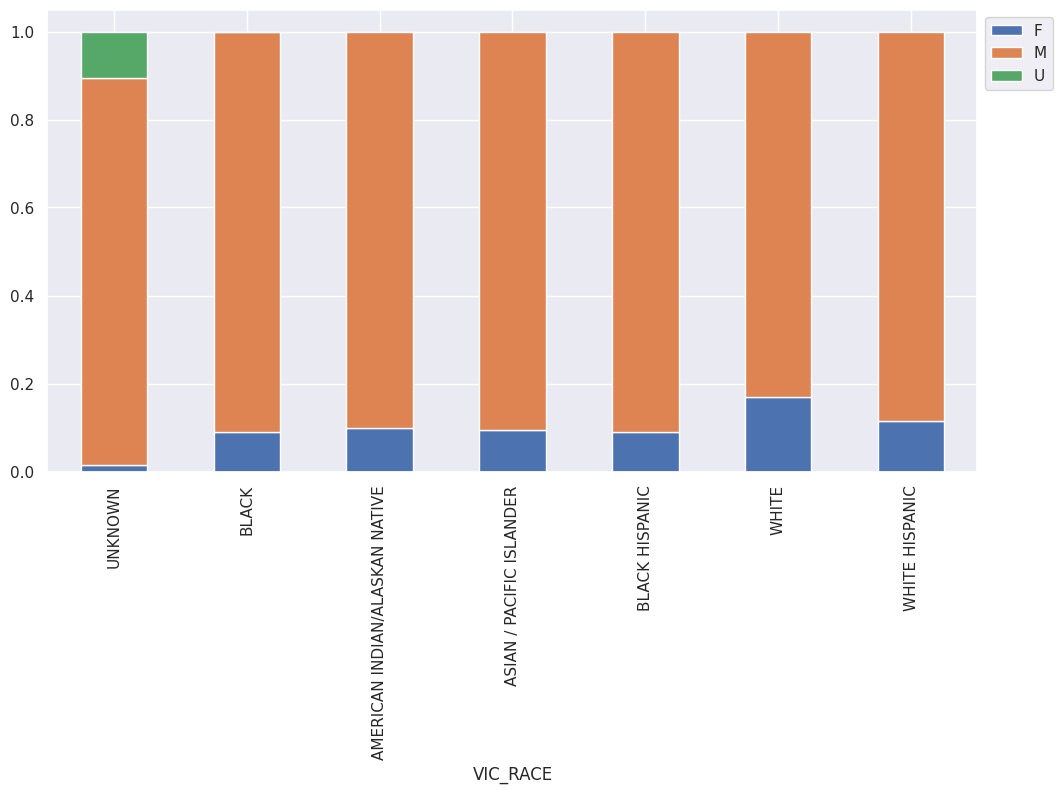

In [50]:
stacked_barplot(data, "VIC_RACE","VIC_SEX")

As I suspected the majority of unknown gender are also unknown race, though a good number are also African American.

Most races have women making about 10% of the vicitm pool though whites it is above 16%, these MAY suggect a difference in cause of violence amongts races but I would need more details to suggest a cause or even prove one exists

VIC_SEX           F      M   U    All
VIC_AGE_GROUP                        
All            2615  24685  11  27311
UNKNOWN           5     51   5     61
18-24           794   9288   4  10086
25-44          1003  11276   2  12281
45-64           347   1516   0   1863
65+              59    122   0    181
<18             407   2432   0   2839
------------------------------------------------------------------------------------------------------------------------


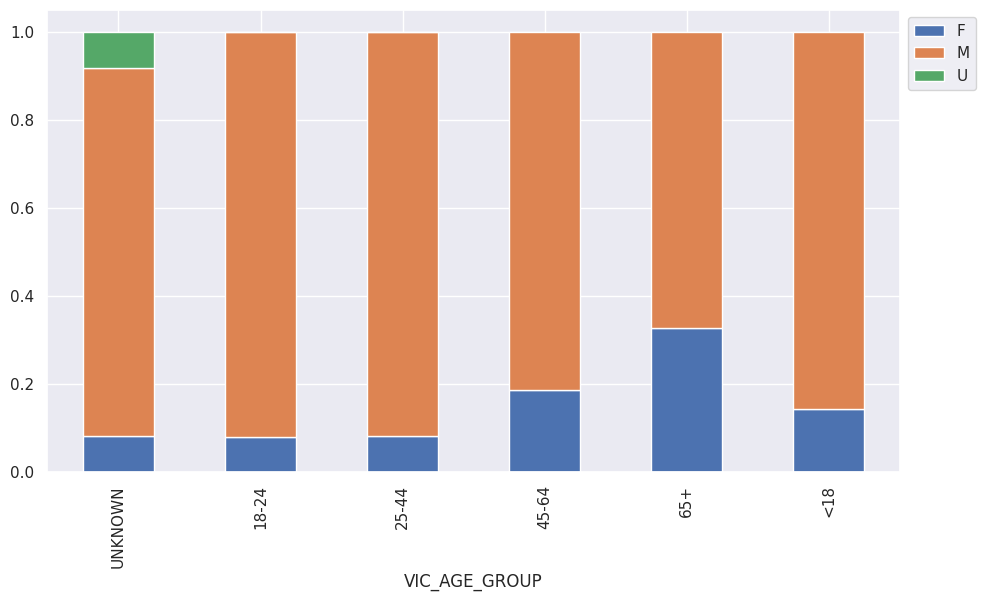

In [52]:
stacked_barplot(data, "VIC_AGE_GROUP","VIC_SEX")

Again unknown seems to be more common with unknown, again suggesting the victim was not known to police.
Interstingly, women make up a larger percentage of the victim pool at ages above 45 and below 18, again suggesting the possibility of differences in victimology

VIC_AGE_GROUP                   18-24  25-44  45-64  65+   <18  UNKNOWN    All
VIC_RACE                                                                      
All                             10086  12281   1863  181  2839       61  27311
BLACK                            7309   8732   1191   95  2093       18  19438
UNKNOWN                            20     21      5    0     4       16     66
WHITE                             146    328    153   29    28       14    698
WHITE HISPANIC                   1494   1839    279   34   395        8   4049
BLACK HISPANIC                    991   1154    178   18   301        4   2646
ASIAN / PACIFIC ISLANDER          121    204     57    5    16        1    404
AMERICAN INDIAN/ALASKAN NATIVE      5      3      0    0     2        0     10
------------------------------------------------------------------------------------------------------------------------


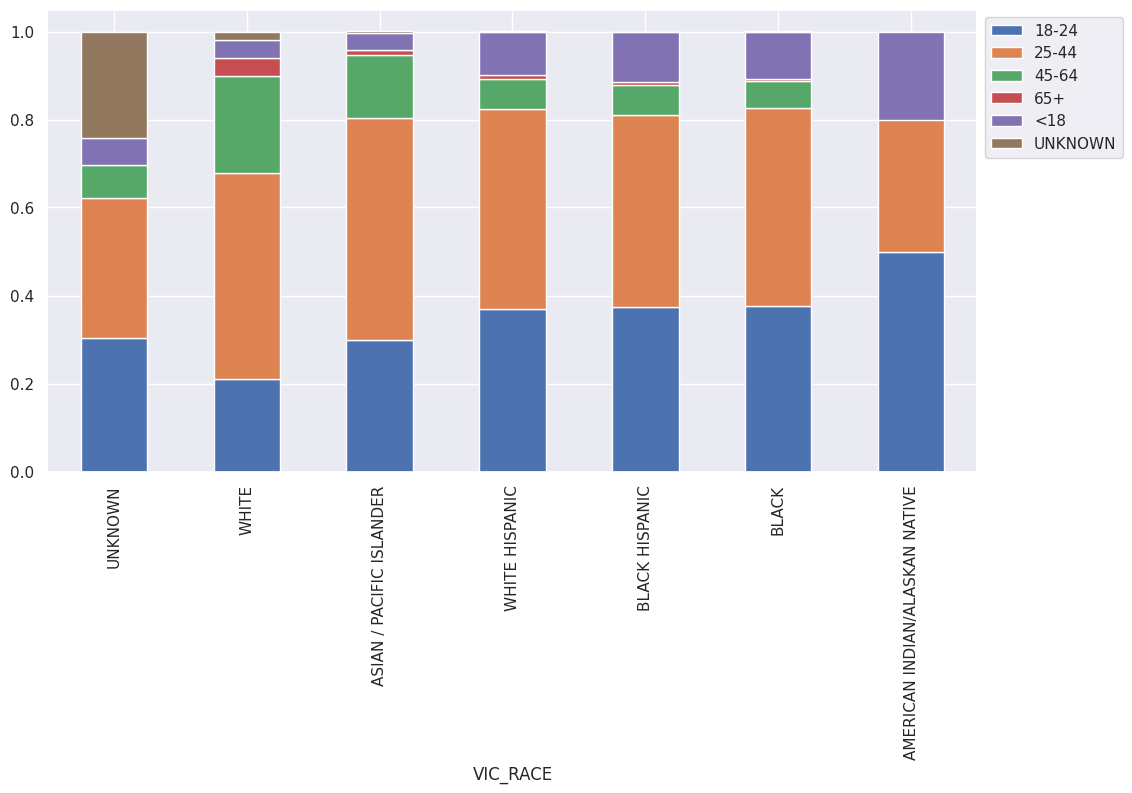

In [53]:
stacked_barplot(data, "VIC_RACE","VIC_AGE_GROUP")

Again, unknown is comon with other unknwon.
Natives and the asain groupo where low, but it is interesting no victims above 44 existed in the Native populus.

There do appear ot be more older victims amonst white citizens than other groups